# Imports and setup

In [431]:
from torch import nn, optim
import torch

from torch.utils.data import DataLoader
from torchvision import models
from facenet_pytorch import InceptionResnetV1
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from PIL import Image
import matplotlib.pyplot as plt


from tqdm import tqdm

In [432]:
import utils
import dataloader

### Check si on peut utiliser cuda

In [433]:
print("Cuda compatible : ", torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else "cpu"

Cuda compatible :  True


# Paramètres

In [434]:
IMAGE_SIZE = 128
NB_IMAGES = 10
EMBEDDING_SIZE = 128
BATCH_SIZE = 32

EPOCHS = 500

# Chargement du dataset

Building dataset 

train samples: 30, test samples: 30, nb_classes: 6


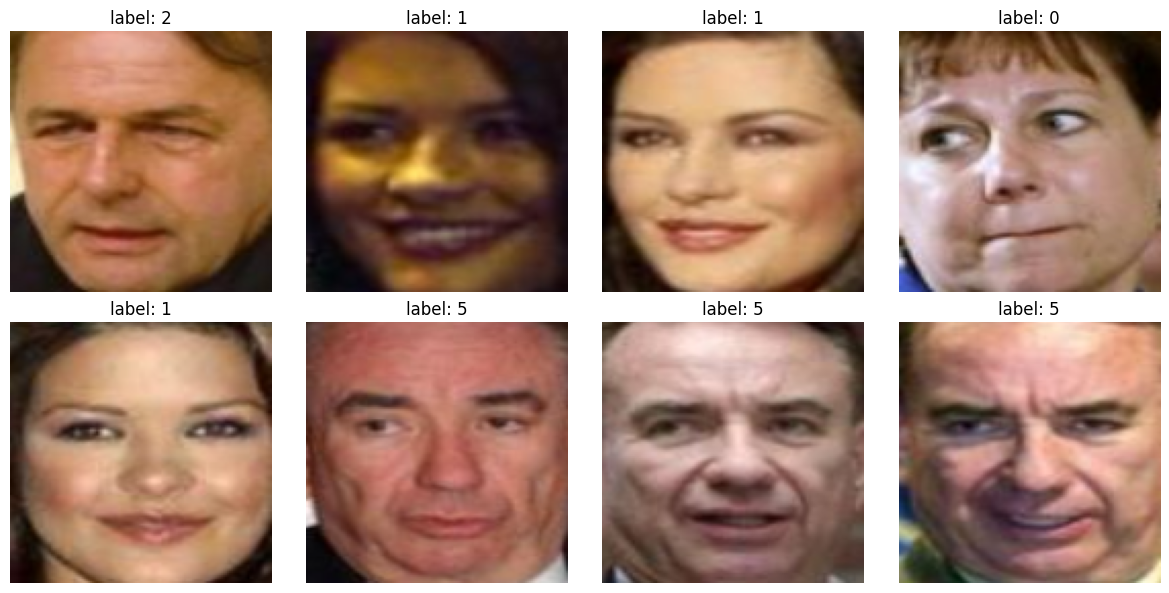

In [435]:
train_dataset, test_dataset, nb_classes = dataloader.make_dataset("dataset/LFW_small", NB_IMAGES, IMAGE_SIZE, 0.5)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"train samples: {len(train_dataset)}, test samples: {len(test_dataset)}, nb_classes: {nb_classes}")

images, labels = next(iter(train_loader))
images = images.cpu()
labels = labels.cpu().numpy()

n = min(8, images.size(0))
imgs = images[:n]
labs = labels[:n]

fig, axs = plt.subplots(2, 4, figsize=(12, 6))
axs = axs.flatten()
for i, ax in enumerate(axs):
    if i < n:
        img = imgs[i].permute(1, 2, 0).numpy()
        mi, ma = img.min(), img.max()
        img_disp = (img - mi) / (ma - mi) if ma - mi > 1e-6 else img
        ax.imshow(img_disp)
        ax.set_title(f"label: {labs[i]}")
    ax.axis("off")
plt.tight_layout()
plt.show()

# Définition des modèles

In [436]:
class Embedder(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(3, 8, 5), # 3 car image RGB, 6 en sortie (6 filtres) , taille noyau de 5
            nn.BatchNorm2d(8), # empeche le collapse des embeddings
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # reduit par 2 la taille
            nn.Conv2d(8, 16, 5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.features = nn.Linear(16 *29*29, EMBEDDING_SIZE )

    def forward(self,x):
        res = self.conv(x)
        res = torch.flatten(res,1)
        res = self.features(res)
        res = res / res.norm(dim= 1, keepdim=True) # normalise la sortie, donne de meilleur resultat
        return res

class Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.fc = nn.Linear(EMBEDDING_SIZE, num_classes)
    def forward(self, x):
        return self.fc(x)

# Embedding

## Entrainement

In [437]:
faceEmbedder = Embedder().to(device)

model_parameters = filter(lambda p: p.requires_grad, faceEmbedder.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"Embedder has {params} parameters")

triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2, eps=1e-7)
optimizer = optim.Adam(faceEmbedder.parameters(), lr=0.0001)

final_embedder_loss = 0.0

faceEmbedder.train()
for epoch in range(EPOCHS):

    total_loss = 0.0

    for images, labels in train_loader:
        #images = torch.flatten(images, 1)

        images = images.to(device)
        labels = labels.to(device)

        output = faceEmbedder(images)
        anchor_idx, positive_idx, negative_idx = utils.get_triplets(labels)

        anchors = output[anchor_idx]
        positives = output[positive_idx]
        negatives = output[negative_idx]

        loss = triplet_loss(anchors,positives, negatives)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        

        total_loss += loss.item()

    total_loss = total_loss / len(train_loader)

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")
    final_embedder_loss = total_loss





#print("Embedder final loss : ", final_embedder_loss)

Embedder has 1726368 parameters
Epoch 1, Loss: 0.9790
Epoch 2, Loss: 0.7303
Epoch 3, Loss: 0.4157
Epoch 4, Loss: 0.2111
Epoch 5, Loss: 0.0873
Epoch 6, Loss: 0.0335
Epoch 7, Loss: 0.0123
Epoch 8, Loss: 0.0042
Epoch 9, Loss: 0.0020
Epoch 10, Loss: 0.0021
Epoch 11, Loss: 0.0021
Epoch 12, Loss: 0.0016
Epoch 13, Loss: 0.0010
Epoch 14, Loss: 0.0007
Epoch 15, Loss: 0.0006
Epoch 16, Loss: 0.0005
Epoch 17, Loss: 0.0003
Epoch 18, Loss: 0.0002
Epoch 19, Loss: 0.0000
Epoch 20, Loss: 0.0000
Epoch 21, Loss: 0.0000
Epoch 22, Loss: 0.0001
Epoch 23, Loss: 0.0001
Epoch 24, Loss: 0.0001
Epoch 25, Loss: 0.0001
Epoch 26, Loss: 0.0001
Epoch 27, Loss: 0.0000
Epoch 28, Loss: 0.0000
Epoch 29, Loss: 0.0000
Epoch 30, Loss: 0.0000
Epoch 31, Loss: 0.0000
Epoch 32, Loss: 0.0000
Epoch 33, Loss: 0.0000
Epoch 34, Loss: 0.0000
Epoch 35, Loss: 0.0000
Epoch 36, Loss: 0.0000
Epoch 37, Loss: 0.0000
Epoch 38, Loss: 0.0000
Epoch 39, Loss: 0.0000
Epoch 40, Loss: 0.0000
Epoch 41, Loss: 0.0000
Epoch 42, Loss: 0.0000
Epoch 43, L

## Analyse

### Calcul tous les embeddings

In [438]:
faceEmbedder.eval()
embeddings = []
with torch.no_grad():
    for images, labels in train_loader:
        #print(labels)
        #images = torch.flatten(images, 1)

        images = images.to(device)
        labels = labels.to(device)

        output = faceEmbedder(images)

        for i in range(output.size(0)):
            embeddings.append([output[i].cpu().tolist(), labels[i].cpu().item()])

    emb_np = np.array([item[0] for item in embeddings])
    lab_np = np.array([item[1] for item in embeddings])

    for cls in range(nb_classes):
        idx = np.where(lab_np == cls)[0]
        avg_emb = emb_np[idx].mean(axis=0)
        print(f"classe {cls}: avg embedding = {avg_emb.tolist()}")

classe 0: avg embedding = [-0.1126488283276558, 0.006645616935566067, 0.06948660165071488, 0.1630301892757416, -0.011704608332365751, 0.08919086307287216, -0.04851956591010094, 0.04598732329905033, 0.15896788239479065, 0.033275279030203816, -0.061291713267564774, -0.11361908316612243, -0.11360782831907272, -0.041164496913552284, -0.08381383493542671, 0.00790481953881681, -0.04363707005977631, 0.04532898850739002, -0.008031615242362022, 0.06449613571166993, -0.10019185543060302, -0.10877726078033448, 0.12515315264463425, -0.07744851186871529, -0.10049621015787125, 0.07281754463911057, -0.004618842422496527, -0.018542356602847577, -0.0545912254601717, 0.16666538119316102, 3.39265214279294e-05, 0.14828342199325562, -0.0168706813827157, 0.03037129957228899, -0.06564080193638802, -0.004862071759998798, -0.10648884922266007, 0.03379671424627304, 0.09829984456300736, 0.11219513565301895, -0.15062175393104554, -0.11300721913576126, -0.030273434799164535, -0.015142073016613722, 0.20172150433063

### Plot embeddings

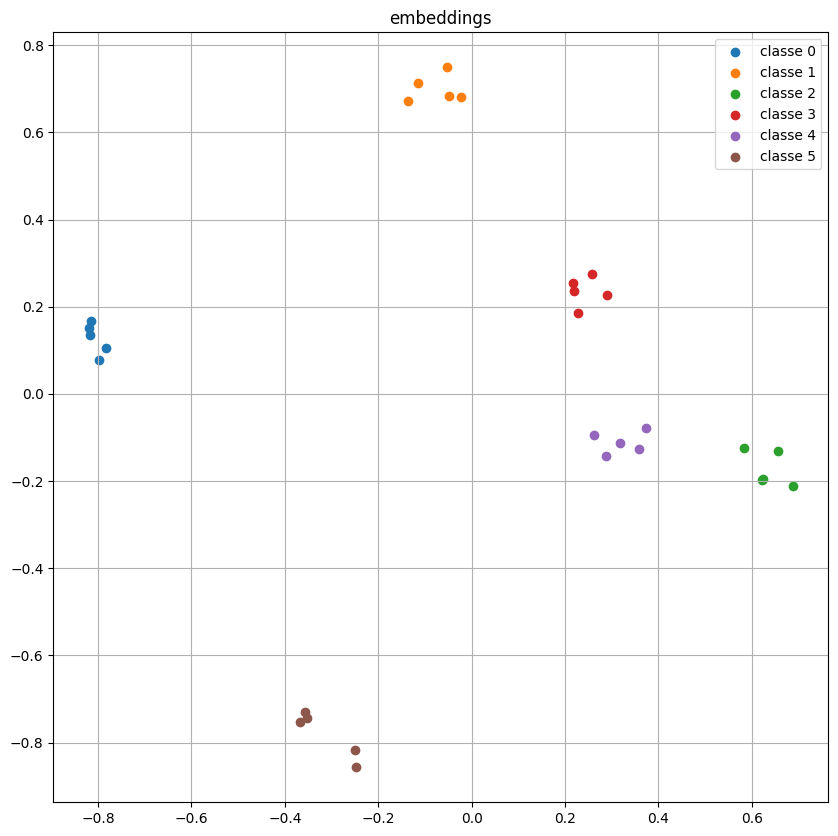

In [439]:
def plot_embeddings():
    embeddings_np = np.array([e[0] for e in embeddings])
    labels_np = np.array([e[1] for e in embeddings])

    pca = PCA(n_components=2) #reduction en 2D
    reduced_embeddings = pca.fit_transform(embeddings_np)

    plt.figure(figsize=(10, 10))
    for label in np.unique(labels_np):
        idx = labels_np == label
        plt.scatter(reduced_embeddings[idx, 0], reduced_embeddings[idx, 1], label=f"classe {label}")

    plt.title("embeddings")
    plt.legend()
    plt.grid(True)
    plt.show()



plot_embeddings()

# Classifieur

## Entrainement

In [440]:

classifier = Classifier(nb_classes).to(device)
crossLoss = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

final_classifier_loss = [0.0,0.0]

losses = []

faceEmbedder.eval()
for epoch in range(EPOCHS):
    total_loss = 0.0
    classifier.train()
    for images, labels in train_loader:
        #images = torch.flatten(images, 1)

        images = images.to(device)
        labels = labels.to(device)

        embeded = faceEmbedder(images)

        output = classifier(embeded)
        loss = crossLoss(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()


    #test avec le set de validation
    classifier.eval()
    total_eval_loss = 0.0
    for images, labels in test_loader:
        #images = torch.flatten(images, 1)
        images = images.to(device)
        labels = labels.to(device)

        embeded = faceEmbedder(images)

        output = classifier(embeded)
        loss = crossLoss(output, labels)

        #metrics
        total_eval_loss += loss.item()


    total_loss = total_loss / len(train_loader)
    total_eval_loss = total_eval_loss / len(test_loader)
    print(f"Epoch {epoch+1}, training loss: {total_loss:.4f}, test loss: {total_eval_loss:.4f}")

    losses.append((total_loss, total_eval_loss))

    final_classifier_loss[0] = total_loss
    final_classifier_loss[1] = total_eval_loss



#print("Classifier final train loss : ", final_classifier_loss[0], " test loss : ", final_classifier_loss[1])

Epoch 1, training loss: 1.7997, test loss: 1.7967
Epoch 2, training loss: 1.7908, test loss: 1.7921
Epoch 3, training loss: 1.7818, test loss: 1.7875
Epoch 4, training loss: 1.7729, test loss: 1.7829
Epoch 5, training loss: 1.7641, test loss: 1.7783
Epoch 6, training loss: 1.7552, test loss: 1.7737
Epoch 7, training loss: 1.7463, test loss: 1.7691
Epoch 8, training loss: 1.7375, test loss: 1.7646
Epoch 9, training loss: 1.7287, test loss: 1.7600
Epoch 10, training loss: 1.7199, test loss: 1.7555
Epoch 11, training loss: 1.7112, test loss: 1.7510
Epoch 12, training loss: 1.7024, test loss: 1.7465
Epoch 13, training loss: 1.6937, test loss: 1.7421
Epoch 14, training loss: 1.6850, test loss: 1.7376
Epoch 15, training loss: 1.6763, test loss: 1.7332
Epoch 16, training loss: 1.6677, test loss: 1.7288
Epoch 17, training loss: 1.6591, test loss: 1.7244
Epoch 18, training loss: 1.6505, test loss: 1.7200
Epoch 19, training loss: 1.6419, test loss: 1.7156
Epoch 20, training loss: 1.6333, test lo

## Analyse

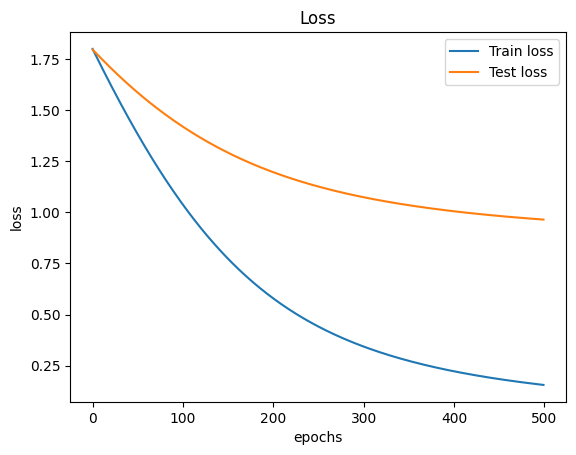

In [441]:
plt.figure()
plt.plot(losses, label="Loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["Train loss", "Test loss"])
plt.show()

### Plot la matrice de confusion et accuracy

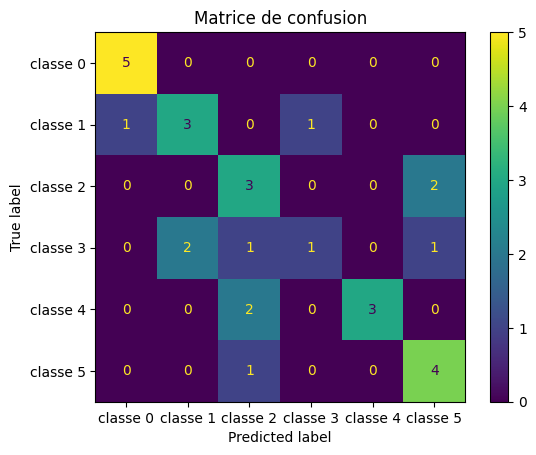

accuracy on test set: 63.33% (19/30)


In [442]:
def plot_confusion_matrix():
    classifier.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            #images = torch.flatten(images, 1)
            images = images.to(device)
            labels = labels.to(device)

            embeded = faceEmbedder(images)
            output = classifier(embeded)
            predictions = torch.argmax(output, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions, labels=range(nb_classes))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"classe {i}" for i in range(nb_classes)])
    disp.plot()
    plt.title("Matrice de confusion")
    plt.show()

plot_confusion_matrix()


classifier.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        #images = torch.flatten(images, 1).to(device)
        images = images.to(device)
        labels = labels.to(device)
        logits = classifier(faceEmbedder(images))
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total if total > 0 else 0.0
print(f"accuracy on test set: {accuracy * 100:.2f}% ({correct}/{total})")

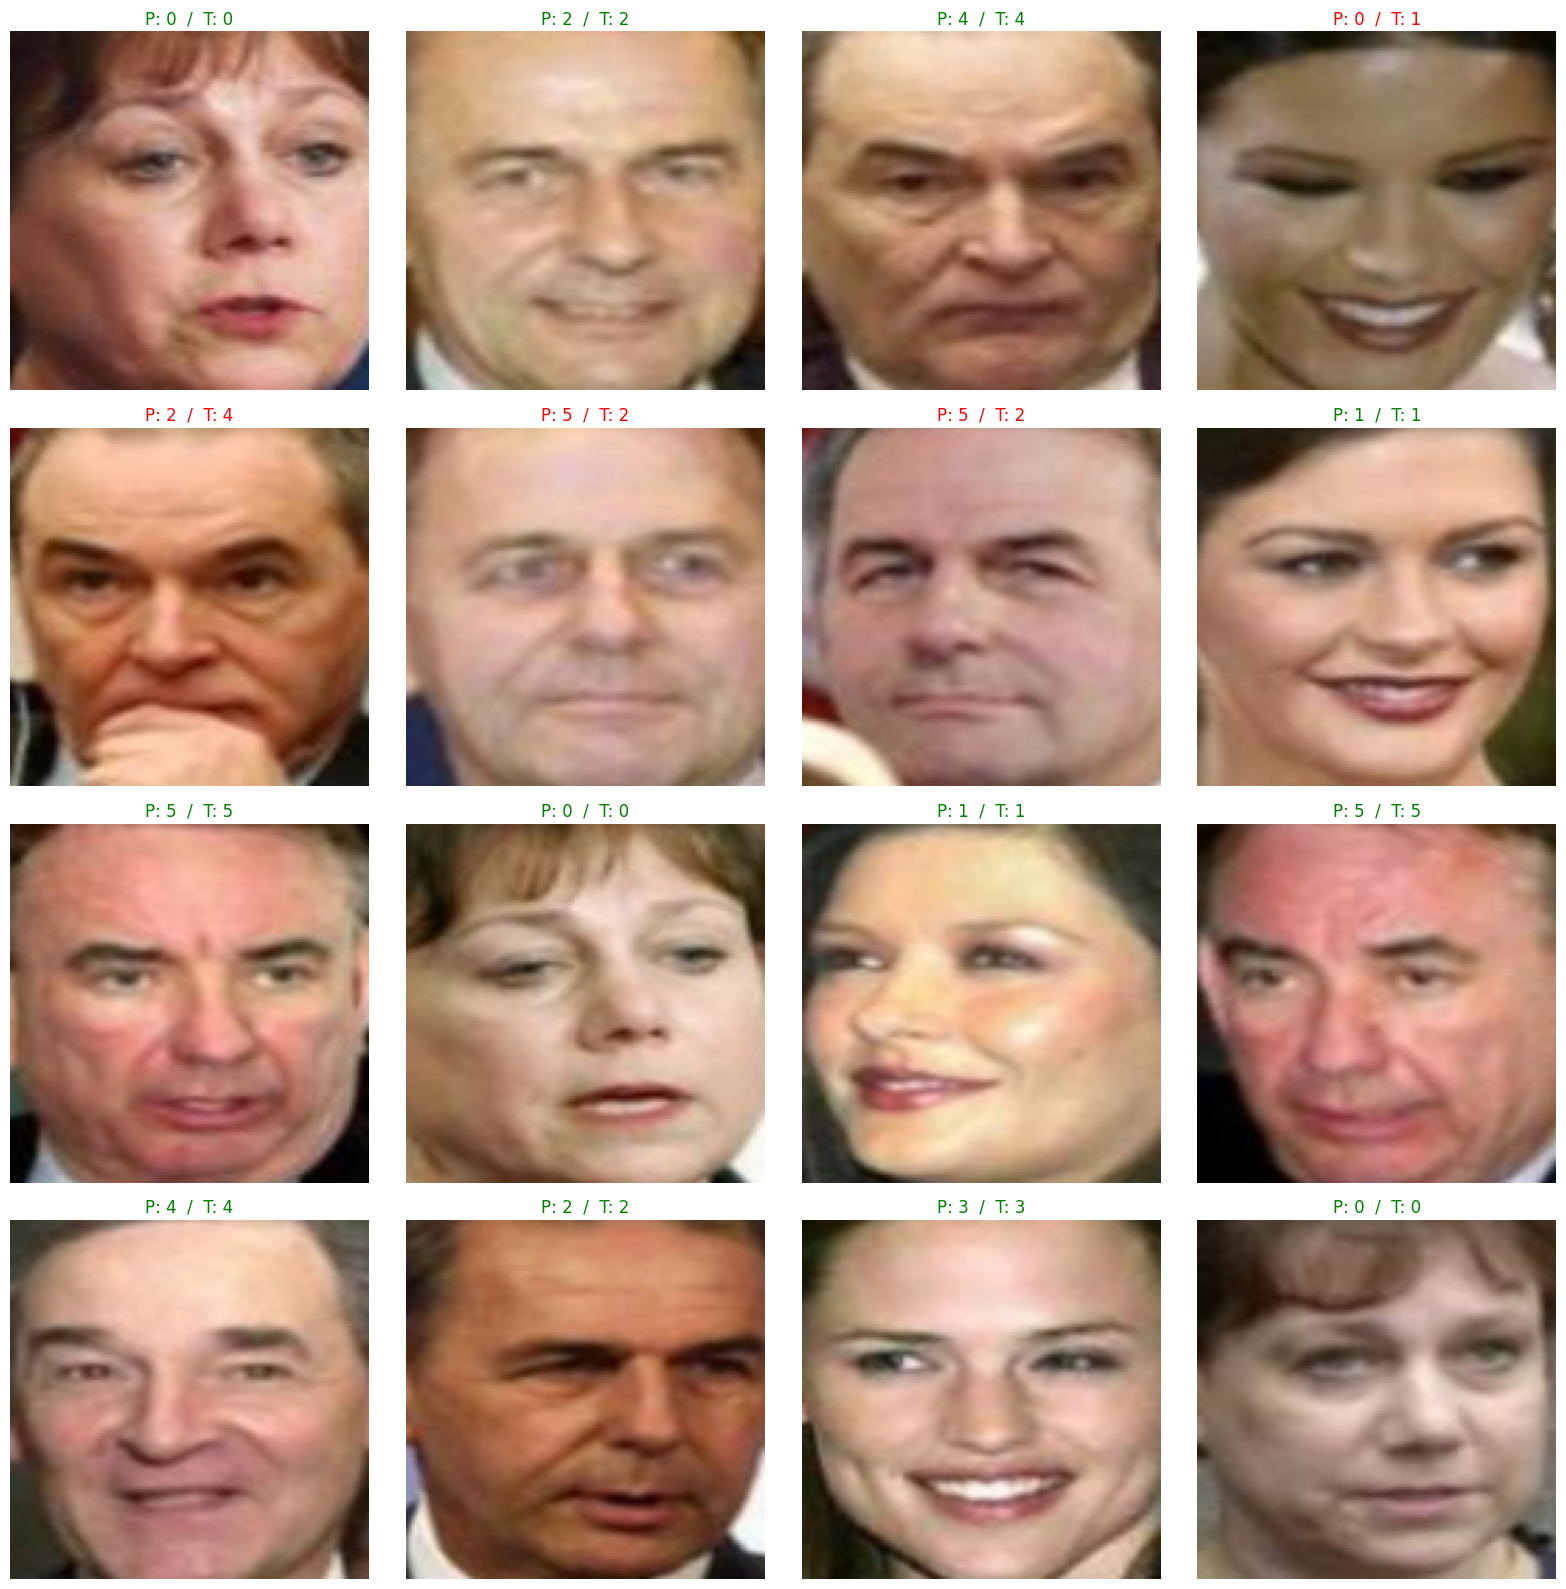

In [443]:
import math

faceEmbedder.eval()
classifier.eval()

num_display = 16 
cols = 4
rows = math.ceil(num_display / cols)

imgs_to_show = []
trues = []
preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images_cpu = images.cpu()
        images_dev = images.to(device)
        labels_dev = labels.to(device)

        embeddings = faceEmbedder(images_dev)
        logits = classifier(embeddings)
        batch_preds = logits.argmax(dim=1).cpu().numpy()
        batch_labels = labels_dev.cpu().numpy()

        for i in range(images_cpu.size(0)):
            imgs_to_show.append(images_cpu[i].permute(1, 2, 0).numpy())
            trues.append(int(batch_labels[i]))
            preds.append(int(batch_preds[i]))
            if len(imgs_to_show) >= num_display:
                break
        if len(imgs_to_show) >= num_display:
            break

fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.axis("off")
    if i < len(imgs_to_show):
        img = imgs_to_show[i]
        mi, ma = img.min(), img.max()
        denom = (ma - mi) if (ma - mi) > 1e-6 else 1.0
        img_disp = (img - mi) / denom
        ax.imshow(img_disp)
        true = trues[i]
        pred = preds[i]
        color = "green" if pred == true else "red"
        ax.set_title(f"P: {pred}  /  T: {true}", color=color, fontsize=12)
plt.tight_layout()
plt.show()